In [ ]:
import wandb
import datasets
from transformers import PreTrainedTokenizerFast, RobertaForSequenceClassification
import os
import tempfile
import torch
import warnings

warnings.filterwarnings("ignore")

BATCH_SIZE = 1024
N_SAMPLES = 100
device = torch.device("mps")
api = wandb.Api()

tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "/Users/henrywilliams/Documents/programming/python/ai/malbert-test/MalBERTa"
)
dataset = datasets.load_from_disk("../data/raw")
processed_dataset = dataset.map(
    handle_sample,
    remove_columns=dataset["test"].column_names,
    batch_size=64,
    batched=True,
    num_proc=8,
    fn_kwargs=dict(tokenizer=tokenizer, args=args),
)

models = {
    "base": {
        "base": "e96b8h5a",
        "pretrained": "e1tosi4k",
        "frozen": "t4o7wvla",
    },
    "ob": {
        "base": "swcod025",
        "pretrained": "xzlusbyu",
        "frozen": "aqzn99cx",
    },
    "pob": {
        "base": "wozkyaa6",
        "pretrained": "daf0h543",
        "frozen": "47y92682",
    },
}

/Users/henrywilliams/Documents/programming/python/ai/malbert-test/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def handle_sample(sample, **kwargs):
    tokenizer = kwargs.get("tokenizer")
    args = kwargs.get("args")

    if tokenizer is None:
        raise Exception("Missing tokenizer")

    if args is None:
        raise Exception("Missing CLI args")

    texts = sample["text"]
    labels = sample["label"]

    flattened = defaultdict(list)

    for text, label in zip(texts, labels):
        tokenized = tokenizer(
            text,
            padding="max_length",
            max_length=args.max_length,
            return_overflowing_tokens=True,
            truncation=True,
        )

        for i in range(len(tokenized["input_ids"])):
            for k in tokenized:
                flattened[k].append(tokenized[k][i])
            flattened["label"].append(label)

    return dict(flattened)


In [ ]:
def get_model(id):
    with tempfile.TemporaryDirectory() as tdir:
        base_artifact = api.artifact(
            f"henry-williams/opcode-malberta/model-{id}:v1", type="model"
        )

        base_path = base_artifact.download(root=os.path.join(tdir, "base"))

        return RobertaForSequenceClassification.from_pretrained(base_path).to(device)


def make_preds(sample, model, tokenizer):
    input = tokenize(model, sample, tokenizer)
    input_ids = torch.tensor(input["input_ids"])
    attention_mask = torch.tensor(input["attention_mask"])
    full_logits = []

    for ids, mask in zip(input_ids.split(BATCH_SIZE), attention_mask.split(BATCH_SIZE)):
        torch.mps.empty_cache()
        with torch.no_grad():
            logits = model(ids.to(device), mask.to(device)).logits
        full_logits.append(logits)

    logits = torch.vstack(full_logits)
    return reduce(logits)


def reduce(preds):
    return preds.mean(dim=0).argmax()

In [3]:
incorrect = {
    "base": {
        "base": None,
        "pretrained": None,
        "frozen": None,
    },
    "ob": {
        "base": None,
        "pretrained": None,
        "frozen": None,
    },
    "pob": {
        "base": None,
        "pretrained": None,
        "frozen": None,
    },
}

In [ ]:
from tqdm import tqdm

selection = dataset["test"].shuffle().select(range(N_SAMPLES))

for ts in ["base", "ob", "pob"]:
    for m in ["pretrained", "base", "frozen"]:
        model = get_model(models[ts][m])
        pred = []
        actual = []

        for sample in tqdm(selection):
            pred.append(make_preds(sample, model, tokenizer))
            actual.append(sample["label"])

        pred = torch.tensor(pred)
        actual = torch.tensor(actual)

        incorrect[ts][m] = pred != actual


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact model-e1tosi4k:v1, 87.83MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.9
100%|██████████| 100/100 [05:37<00:00,  3.37s/it]
wandb: Downloading large artifact model-e96b8h5a:v1, 87.83MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.8
100%|██████████| 100/100 [04:53<00:00,  2.93s/it]
wandb: Downloading large artifact model-t4o7wvla:v1, 87.83MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.7
100%|██████████| 100/100 [05:24<00:00,  3.24s/it]
wandb: Downloading large artifact model-xzlusbyu:v1, 87.83MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.9
100%|██████████| 100/100 [04:56<00:00,  2.97s/it]
wandb: Downloading large artifact model-swcod025:v1, 87.83MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.7
100%|██████████| 100/100 [04:48<00:00,  2.89s/it]
wandb: Downloading 

In [7]:
# pred, actual = torch.tensor(pred), torch.tensor(actual)

torch.count_nonzero(pred != actual) / torch.numel(pred)

tensor(0.1800)

In [8]:
incorrect

{'base': {'base': tensor([False,  True, False, False, False,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False,  True, False, False, False,
          False, False, False, False, False, False,  True, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False,  True, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False,  True, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False]),
  'pretrained': tensor([False,  True, False, False, False,  True, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
        

In [ ]:
mat = np.zeros((9, 100))
i = 0

for vs in incorrect.values():
    for v in vs.values():
        mat[i, :] = v
        i += 1
mat

array([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.

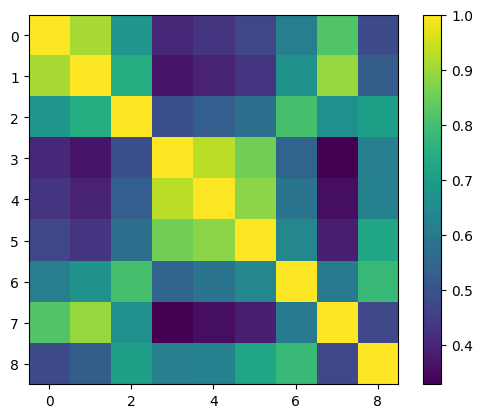

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

plt.imshow(cosine_similarity(mat))
plt.colorbar()